In [85]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

sys.path.append("..")

from cyclops.feature_handler import FeatureHandler
from drift_detector.explainer import ShiftExplainer
from experiments import *
from utils.constants import *
from utils.plot_utils import errorfill, plot_roc, plot_pr, linestyles, markers, colors, brightness, colorscale
from utils.utils import run_shift_experiment, get_gemini_data, import_dataset_hospital, get_dataset_hospital
from baseline_models.static.utils import run_model

# Config Parameters #

In [86]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022"
DATASET = "gemini"
SAMPLES = [10, 20, 50, 100, 200, 500, 1000]
RANDOM_RUNS = 5
SIGN_LEVEL = 0.05
CALC_ACC = True
TIMESTEPS = 6
AGGREGATION_TYPE = "mean"
SCALE="scale"
DR_TECHNIQUES = ["NoRed","SRP", "PCA", "kPCA", "Isomap","BBSDs_FFNN"]
MD_TESTS = ["LSDD", "MMD", "LK","Classifier"]

# Query Data

In [63]:
admin_data, x, y = get_gemini_data(PATH)

2022-07-05 17:14:08,302 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-07-05 17:14:08,590 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-07-05 17:14:08,694 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:14:08,698 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:14:08,700 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:14:08,727 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-07-05 17:14:13,491 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-07-05 17:14:21,905 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


# Input Parameters #

In [64]:
SHIFT = input("Select experiment: ")  # covid,seasonal,hosp_type
OUTCOME = input("Select outcome variable: ") # mortality
if SHIFT != "hosp_type":
    HOSPITAL = input("Select hospital: ") # SMH,MSH,THPC,THPM,UHNTG,UHNTW,PMH
    HOSPITAL = HOSPITAL.split(',')

if SHIFT == "covid":
    EXPERIMENTS = ["pre-covid", "covid"]

if SHIFT == "seasonal":
    EXPERIMENTS = ["summer", "winter", "seasonal"]

if SHIFT == "hosp_type":
    EXPERIMENTS = ["academic", "community", "hosp_type"]
    HOSPITAL = ["SMH"]


Select experiment:  covid
Select outcome variable:  mortality
Select hospital:  SMH


# Drift Tests #

In [68]:
# Run shift experiments
if os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"])), "rb") as f:
        mean_dr_md_pval = pickle.load(f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_dist.pkl"])), "rb") as f:
        mean_dr_md_dist = pickle.load(f)
else:
    mean_dr_md_pval = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)
    mean_dr_md_dist = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

if os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"])), "rb") as f:
        std_dr_md_pval = pickle.load(f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_dist.pkl"])), "rb") as f:
        std_dr_md_dist = pickle.load(f)
        
else:
    std_dr_md_pval = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)
    std_dr_md_dist = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

for si, SHIFT in enumerate(EXPERIMENTS):
    for di, DR_TECHNIQUE in enumerate(DR_TECHNIQUES):
        for mi, MD_TEST in enumerate(MD_TESTS):
            if np.any(mean_dr_md_pval[si, di, mi, :] == -1):
                print(
                    "{} | {} | {} | {}".format(
                        SHIFT, HOSPITAL, DR_TECHNIQUE, MD_TEST
                    )
                )
                try:
                    mean_p_vals, std_p_vals, mean_dist, std_dist = run_shift_experiment(
                        shift=SHIFT,
                        admin_data=admin_data,
                        x=x, 
                        y=y,
                        outcome=OUTCOME,
                        hospital=HOSPITAL,
                        path=PATH,
                        aggregation_type=AGGREGATION_TYPE,
                        scale=SCALE,
                        dr_technique=DR_TECHNIQUE,
                        md_test=MD_TEST,
                        samples=SAMPLES,
                        dataset=DATASET,
                        sign_level=SIGN_LEVEL,
                        timesteps=TIMESTEPS,
                        random_runs=RANDOM_RUNS,
                        calc_acc=CALC_ACC
                    )
                    
                    mean_dr_md_pval[si, di, mi, :] = mean_p_vals
                    std_dr_md_pval[si, di, mi, :] = std_p_vals
                    mean_dr_md_dist[si, di, mi, :] = mean_dist
                    std_dr_md_dist[si, di, mi, :] = std_dist
                except ValueError as e:
                    print("Value Error")
                    pass

2022-07-05 17:16:12,322 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:16:12,324 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:16:12,325 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:16:12,355 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | NoRed | LSDD


2022-07-05 17:16:17,171 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:16:20,203 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:16:20,207 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:16:20,210 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:16:20,243 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | NoRed | MMD


2022-07-05 17:16:25,051 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:16:28,362 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:16:28,364 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:16:28,367 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:16:28,395 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | NoRed | LK


2022-07-05 17:16:33,234 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:16:40,804 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:16:40,808 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:16:40,809 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:16:40,838 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | NoRed | Classifier


2022-07-05 17:16:45,626 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:16:49,726 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:16:49,727 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:16:49,733 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:16:49,764 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | SRP | LSDD


2022-07-05 17:16:54,569 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:16:57,900 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:16:57,901 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:16:57,904 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:16:57,932 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | SRP | MMD


2022-07-05 17:17:02,737 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:17:07,111 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:17:07,116 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:17:07,119 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:17:07,152 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | SRP | LK


2022-07-05 17:17:11,980 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:17:19,964 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:17:19,966 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:17:19,967 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:17:19,995 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | SRP | Classifier


2022-07-05 17:17:24,763 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:17:28,819 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:17:28,821 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:17:28,823 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:17:28,851 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | PCA | LSDD


2022-07-05 17:17:33,643 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:17:37,297 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:17:37,302 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:17:37,305 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:17:37,337 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | PCA | MMD


2022-07-05 17:17:42,153 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:17:47,272 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:17:47,274 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:17:47,277 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:17:47,318 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | PCA | LK


2022-07-05 17:17:52,113 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:18:01,005 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:18:01,007 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:18:01,009 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:18:01,039 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | PCA | Classifier


2022-07-05 17:18:05,801 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:18:10,803 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:18:10,808 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:18:10,812 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:18:10,841 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | kPCA | LSDD


2022-07-05 17:18:15,636 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:18:20,594 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:18:20,599 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:18:20,602 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:18:20,632 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | kPCA | MMD


2022-07-05 17:18:25,418 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:18:30,266 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:18:30,270 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:18:30,273 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:18:30,302 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | kPCA | LK


2022-07-05 17:18:35,058 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:18:43,741 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:18:43,742 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:18:43,744 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:18:43,772 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | kPCA | Classifier


2022-07-05 17:18:48,572 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:18:53,232 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:18:53,236 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:18:53,237 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:18:53,272 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | Isomap | LSDD


2022-07-05 17:18:58,046 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:19:02,481 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:19:02,483 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:19:02,486 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:19:02,528 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | Isomap | MMD


2022-07-05 17:19:07,291 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:19:13,952 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:19:13,957 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:19:13,961 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:19:13,990 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | Isomap | LK


2022-07-05 17:19:18,722 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:19:28,368 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:19:28,373 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:19:28,377 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:19:28,407 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | Isomap | Classifier


2022-07-05 17:19:33,175 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:19:38,471 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:19:38,473 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:19:38,477 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:19:38,504 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | BBSDs_FFNN | LSDD


2022-07-05 17:19:43,262 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:19:46,544 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:19:46,548 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:19:46,552 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:19:46,583 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | BBSDs_FFNN | MMD


2022-07-05 17:19:51,356 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:19:54,883 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:19:54,888 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:19:54,891 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:19:54,925 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | BBSDs_FFNN | LK


2022-07-05 17:19:59,702 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:20:06,999 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:20:07,000 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:20:07,004 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:20:07,032 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH'] | BBSDs_FFNN | Classifier


2022-07-05 17:20:11,797 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:20:15,721 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:20:15,726 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:20:15,729 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:20:15,759 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | NoRed | LSDD


2022-07-05 17:20:20,491 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:20:24,841 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:20:24,845 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:20:24,848 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:20:24,878 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | NoRed | MMD


2022-07-05 17:20:29,605 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:20:34,469 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:20:34,471 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:20:34,474 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:20:34,504 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | NoRed | LK


2022-07-05 17:20:39,223 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:20:53,475 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:20:53,477 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:20:53,479 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:20:53,510 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | NoRed | Classifier


2022-07-05 17:20:58,248 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:21:03,970 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:21:03,971 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:21:03,974 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:21:04,004 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | SRP | LSDD


2022-07-05 17:21:08,790 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:21:13,275 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:21:13,277 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:21:13,279 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:21:13,307 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | SRP | MMD


2022-07-05 17:21:18,067 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:21:23,471 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:21:23,473 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:21:23,475 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:21:23,512 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | SRP | LK


2022-07-05 17:21:28,276 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:21:43,032 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:21:43,034 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:21:43,038 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:21:43,069 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | SRP | Classifier


2022-07-05 17:21:47,856 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:21:54,267 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:21:54,268 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:21:54,272 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:21:54,304 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | PCA | LSDD


2022-07-05 17:21:59,044 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:22:07,423 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:22:07,431 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:22:07,435 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:22:07,480 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | PCA | MMD


2022-07-05 17:22:12,273 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:22:18,758 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:22:18,762 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:22:18,765 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:22:18,797 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | PCA | LK


2022-07-05 17:22:23,544 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:22:39,078 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:22:39,082 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:22:39,085 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:22:39,114 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | PCA | Classifier


2022-07-05 17:22:43,891 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:22:51,510 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:22:51,512 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:22:51,515 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:22:51,550 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | kPCA | LSDD


2022-07-05 17:22:56,284 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:23:04,220 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:23:04,221 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:23:04,224 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:23:04,259 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | kPCA | MMD


2022-07-05 17:23:09,017 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:23:15,719 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:23:15,721 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:23:15,724 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:23:15,757 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | kPCA | LK


2022-07-05 17:23:20,532 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:23:36,567 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:23:36,571 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:23:36,574 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:23:36,607 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | kPCA | Classifier


2022-07-05 17:23:41,350 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:23:48,199 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:23:48,200 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:23:48,203 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:23:48,233 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | Isomap | LSDD


2022-07-05 17:23:52,979 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:24:01,781 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:24:01,783 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:24:01,785 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:24:01,822 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | Isomap | MMD


2022-07-05 17:24:06,564 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:24:14,832 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:24:14,837 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:24:14,840 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:24:14,882 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | Isomap | LK


2022-07-05 17:24:19,623 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:24:39,059 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:24:39,063 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:24:39,066 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:24:39,096 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | Isomap | Classifier


2022-07-05 17:24:43,895 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:24:54,031 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:24:54,032 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:24:54,035 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:24:54,068 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | BBSDs_FFNN | LSDD


2022-07-05 17:24:58,773 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:25:03,280 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:25:03,282 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:25:03,284 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:25:03,314 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | BBSDs_FFNN | MMD


2022-07-05 17:25:08,047 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:25:13,617 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:25:13,621 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:25:13,625 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:25:13,654 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | BBSDs_FFNN | LK


2022-07-05 17:25:18,399 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-05 17:25:32,857 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:25:32,859 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:25:32,860 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:25:32,889 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH'] | BBSDs_FFNN | Classifier


2022-07-05 17:25:37,663 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Select Pre-Processing:  kPCA
Select Two-Sample Testing:  MMD


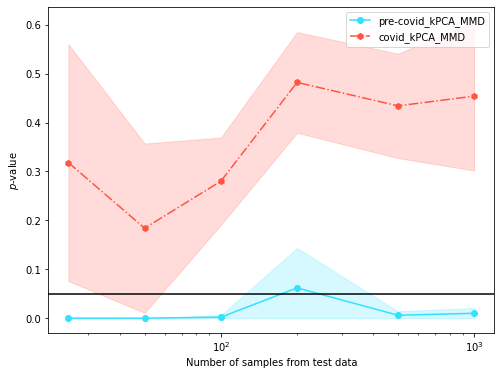

In [79]:
DIM_RED = input("Select Pre-Processing: ")
MD_TEST = input("Select Two-Sample Testing: ")

fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(EXPERIMENTS):
    for di, dr_technique in enumerate(DR_TECHNIQUES):
        for mi, md_test in enumerate(MD_TESTS):
            if (
                    dr_technique == DIM_RED
                    and md_test == MD_TEST
            ):
                errorfill(
                        np.array(SAMPLES),
                        mean_dr_md_pval[si, di, mi, :],
                        std_dr_md_pval[si, di, mi, :],
                        fmt=linestyles[si] + markers[si],
                        color=colorscale(colors[si], brightness[si]),
                        label="%s" % "_".join([shift, dr_technique, md_test]),
                )
plt.xlabel("Number of samples from test data")
plt.ylabel("$p$-value")
plt.axhline(y=SIGN_LEVEL, color="k")
plt.legend()
plt.show()

# Run shift experiments
if not os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"])), "wb") as f:
        pickle.dump(mean_dr_md_pval, f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_dist.pkl"])), "wb") as f:
        pickle.dump(mean_dr_md_dist, f)
if not os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"])), "wb") as f:
        pickle.dump(std_dr_md_pval, f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_dist.pkl"])), "wb") as f:
        pickle.dump(std_dr_md_dist, f)

# Build Model #

In [ ]:
(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, orig_dims, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITAL, 1, shuffle=True)

MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT, OUTCOME, '_'.join(HOSPITAL), MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_tr, y_tr, X_val, y_val)

### Performance on Source Data ###

<AxesSubplot:title={'center':'Average Precision: 0.962282'}, xlabel='Recall', ylabel='Precision'>

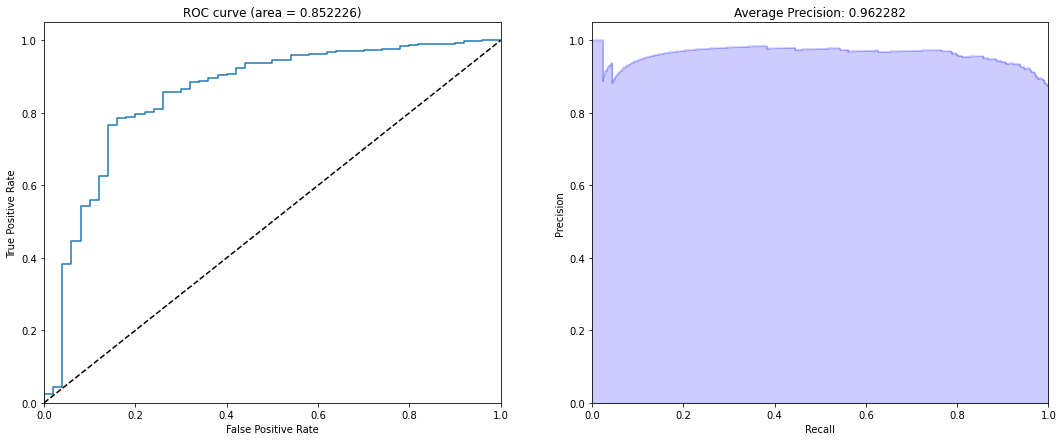

In [17]:
y_pred_prob = optimised_model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

### Performance on Target Data ###

<AxesSubplot:title={'center':'Average Precision: 0.913662'}, xlabel='Recall', ylabel='Precision'>

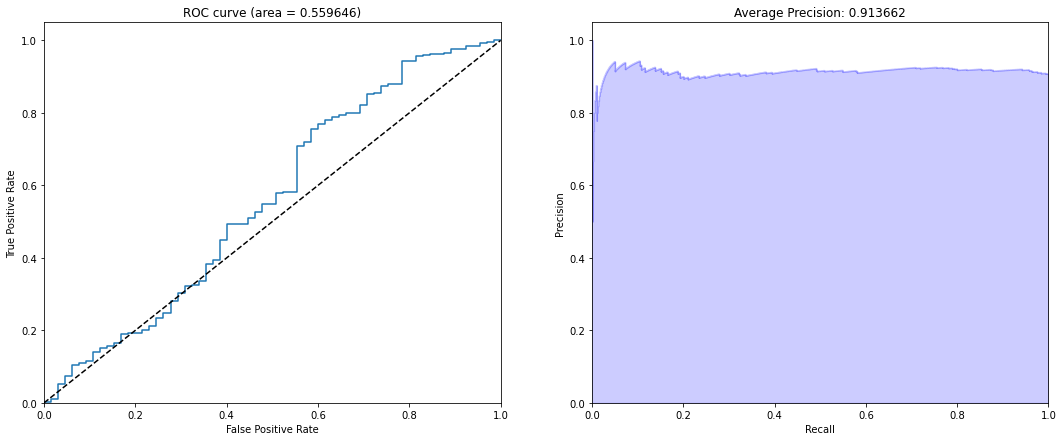

In [18]:
y_pred_prob = optimised_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

## Performance by Sample Size ##

In [19]:
samp_metrics = np.ones((len(SAMPLES), RANDOM_RUNS, 2, 2)) * (-1)
for si, sample in enumerate(SAMPLES):
    for i in range(0, RANDOM_RUNS - 1):
        i = int(i)
        np.random.seed(i)
        X_val, y_val = unison_shuffled_copies(X_val, y_val)
        X_test, y_test = unison_shuffled_copies(X_test, y_test)

        y_val_pred_prob = optimised_model.predict_proba(X_val[:sample])[:, 1]
        val_fpr, val_tpr, val_thresholds = roc_curve(
            y_val[:sample], y_val_pred_prob, pos_label=1
        )
        val_roc_auc = auc(val_fpr, val_tpr)
        val_avg_pr = average_precision_score(y_val[:sample], y_val_pred_prob)

        y_test_pred_prob = optimised_model.predict_proba(X_test[:sample])[:, 1]
        test_fpr, test_tpr, test_thresholds = roc_curve(
            y_test[:sample], y_test_pred_prob, pos_label=1
        )
        test_roc_auc = auc(test_fpr, test_tpr)
        test_avg_pr = average_precision_score(y_test[:sample], y_test_pred_prob)

        samp_metrics[si, i, 0, :] = [val_roc_auc, val_avg_pr]
        samp_metrics[si, i, 1, :] = [test_roc_auc, test_avg_pr]

    mean_samp_metrics = np.mean(samp_metrics, axis=1)
    std_samp_metrics = np.std(samp_metrics, axis=1)

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
torch.range is deprecated and will b

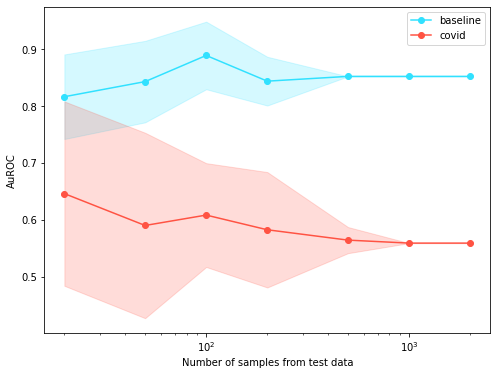

In [21]:
fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(["baseline", SHIFT]):
    for mi, metric in enumerate(["AuROC", "Avg Pr"]):
        if metric == "AuROC":
            errorfill(
                np.array(SAMPLES[1:]),
                mean_samp_metrics[1:, si, mi],
                std_samp_metrics[1:, si, mi],
                fmt=linestyles[mi] + markers[mi],
                color=colorscale(colors[si], brightness[si]),
                label="%s" % "_".join([shift]),
            )
plt.xlabel("Number of samples from test data")
plt.ylabel("AuROC")
plt.legend()
plt.show()

## Explain Difference in Model Predictions ## 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


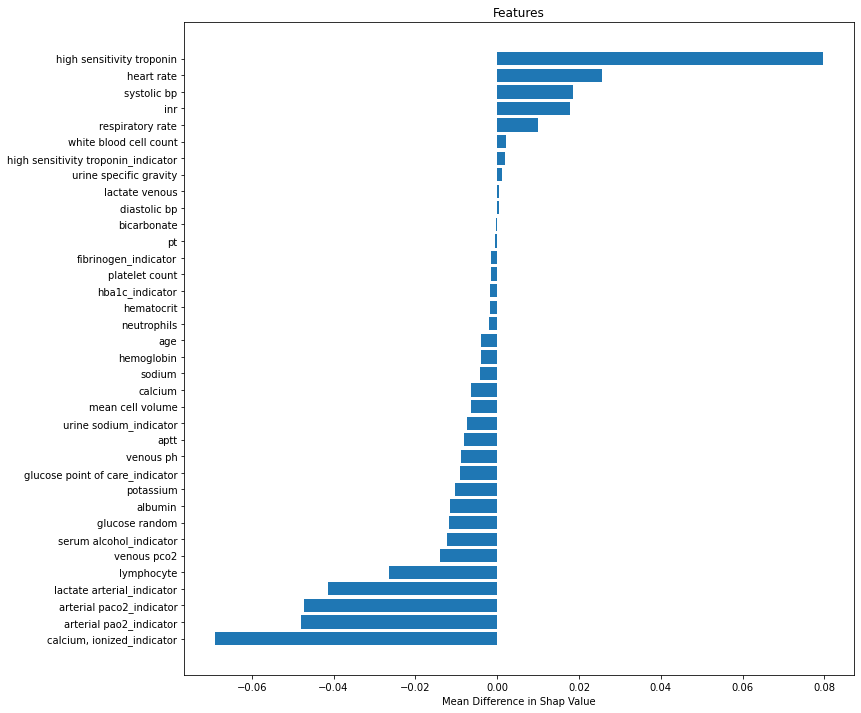

In [22]:
explainer = ShiftExplainer(optimised_model)
explainer.get_explainer()

X_val_df = pd.DataFrame(X_val, columns=feats)
val_shap_values = explainer.get_shap_values(X_val_df)
X_test_df = pd.DataFrame(X_test, columns=feats)
test_shap_values = explainer.get_shap_values(X_test_df)

diff = np.mean(np.abs(test_shap_values.values), axis=0) - np.mean(
    np.abs(val_shap_values.values), axis=0
)
diff_sorted, feats_sorted = zip(*sorted(zip(diff, feats), reverse=True))
diff_sorted, feats_sorted = zip(
    *(((x, y) for x, y in zip(diff_sorted, feats_sorted) if x != 0))
)
fig, ax = plt.subplots(figsize=(12, 12))
y_pos = np.arange(len(diff_sorted))
ax.barh(y_pos, diff_sorted, align="center")
ax.set_yticks(y_pos, labels=feats_sorted)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Mean Difference in Shap Value")
ax.set_title("Features")
plt.show()

In [80]:
from cyclops.feature_handler import FeatureHandler

scale=True
#SHIFT="summer"
OUTCOME="mortality"
#HOSPITAL=["MSH"]
feature_handler = FeatureHandler()
feature_handler.load(PATH, "features")
numerical_cols = feature_handler.get_numerical_feature_names()["temporal"]
numerical_cols += ["age"]
    
(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, orig_dims, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITAL, 1, shuffle=True)

from sklearn.preprocessing import StandardScaler
X_tr_normalized = X_tr.groupby(level=[0]).last()#first()
X_val_normalized = X_val.groupby(level=[0]).last()#first()
X_t_normalized = X_t.groupby(level=[0]).last()#first()

#X_tr_normalized = X_tr.copy()
#X_val_normalized = X_val.copy()
#X_t_normalized = X_t.copy()


if scale:
    for col in numerical_cols:
        scaler = StandardScaler().fit(X_tr_normalized[col].values.reshape(-1, 1))
        X_tr_normalized[col] = pd.Series(
            np.squeeze(scaler.transform(X_tr_normalized[col].values.reshape(-1, 1))),
            index=X_tr_normalized[col].index,
        )
        X_val_normalized[col] = pd.Series(
            np.squeeze(scaler.transform(X_val_normalized[col].values.reshape(-1, 1))),
            index=X_val_normalized[col].index,
        )
        X_t_normalized[col] = pd.Series(
            np.squeeze(scaler.transform(X_t_normalized[col].values.reshape(-1, 1))),
            index=X_t_normalized[col].index,
        )

X_tr_final = X_tr_normalized.dropna().to_numpy()
X_val_final = X_val_normalized.dropna().to_numpy()
X_t_final = X_t_normalized.dropna().to_numpy()        

#X_tr_final = X_tr_normalized.unstack(1).dropna().to_numpy()
#X_val_final = X_val_normalized.unstack(1).dropna().to_numpy()
#X_t_final = X_t_normalized.unstack(1).dropna().to_numpy()          

sys.path.append("..")

from drift_detector.detector import ShiftDetector
from drift_detector.reductor import ShiftReductor

sample=100
timesteps=6
dr_technique="NoRed"
md_test="LSDD"
shift_reductor = ShiftReductor(
            X_tr_final, y_tr, dr_technique, orig_dims, DATASET, dr_amount=None, var_ret=0.9, scale=False, scaler="standard", model=None
)

shift_detector = ShiftDetector(
                dr_technique, md_test, SIGN_LEVEL, shift_reductor, sample, DATASET
)

(p_val,
 dist,
 val_acc,
 te_acc,
) = shift_detector.detect_data_shift(
                X_tr_final, y_tr, X_val_final, y_val, X_t_final[:sample,:], y_t[:sample], orig_dims
)

X_tr_final.shape, X_val_final.shape, X_t_final.shape

p_val

2022-07-05 17:36:10,315 INFO cyclops.feature_handler - Loading features from file...
2022-07-05 17:36:10,317 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-05 17:36:10,318 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-05 17:36:10,345 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-07-05 17:36:15,060 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


0.5399999618530273

In [81]:
X_val_normalized

,age,albumin,albumin_indicator,aptt,aptt_indicator,arterial paco2,arterial paco2_indicator,arterial pao2,arterial pao2_indicator,arterial ph,...,venous pco2_indicator,venous ph,venous ph_indicator,vitamin b12,vitamin b12_indicator,vitamin d,vitamin d_indicator,white blood cell count,white blood cell count_indicator,x-ray
encounter_id,,,,,,,,,,,,,,,,,,,,,
11100856,1.156679,0.009583,0,0.184130,0,1.043150,0,-0.055069,0,-0.465261,...,0,-0.384364,0,-0.994695,0,-0.533147,0,-0.174462,0,1
11103117,-0.114244,1.055060,0,-0.145082,0,1.043150,0,-0.055069,0,-0.465261,...,0,-0.260651,0,-1.067831,0,-0.533147,0,-0.780966,1,0
11104582,-1.108879,-0.737186,0,0.388468,0,1.043150,0,-0.055069,0,-0.465261,...,0,0.976480,0,-1.067831,0,-0.533147,0,0.793365,1,1
11112932,1.156679,1.204414,0,0.286299,0,-0.200130,0,-0.545965,0,-3.304942,...,0,-0.260651,0,1.818026,0,-0.533147,0,0.394620,0,1
11117740,0.106786,-0.886540,0,0.064932,0,-0.682597,0,0.401678,0,0.181922,...,0,-0.446221,0,-0.330368,0,-0.193256,0,0.888857,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11987986,0.935649,1.055060,0,-0.411857,0,0.096773,0,3.193381,0,0.023429,...,0,0.976480,0,-0.976410,0,-0.605981,0,-0.473843,0,1
11993143,-1.274652,-2.380079,0,-0.105350,0,0.096773,0,3.193381,0,0.023429,...,0,-0.590553,0,-1.073926,0,0.000968,0,-0.445453,0,1
11993279,0.935649,0.457644,0,-0.411857,0,2.731784,0,-0.750860,0,-0.372806,...,0,-1.312213,0,-1.332952,0,0.000968,0,1.590854,0,1


In [82]:
X_t_normalized

,age,albumin,albumin_indicator,aptt,aptt_indicator,arterial paco2,arterial paco2_indicator,arterial pao2,arterial pao2_indicator,arterial ph,...,venous pco2_indicator,venous ph,venous ph_indicator,vitamin b12,vitamin b12_indicator,vitamin d,vitamin d_indicator,white blood cell count,white blood cell count_indicator,x-ray
encounter_id,,,,,,,,,,,,,,,,,,,,,
11105194,-1.882484,0.905706,0,-0.655927,0,-0.311469,0,-0.443517,0,0.895145,...,0,-0.136938,0,-1.067831,0,-0.533147,0,0.510759,0,1
11121597,0.659361,-0.886540,0,-0.650251,0,-0.645484,0,-0.059338,0,0.419663,...,0,0.605340,0,-0.561968,0,-0.193256,0,0.763685,0,1
11130949,1.156679,-0.065094,0,0.904989,0,0.282337,0,0.504125,0,-0.848287,...,0,-0.600862,0,-0.872800,0,1.336256,0,-0.505458,0,1
11141777,0.714619,1.055060,0,1.052567,0,-0.478476,0,-0.878920,0,0.895145,...,0,0.234201,0,0.352242,0,1.336256,0,0.319775,0,1
11147990,0.217301,1.055060,0,-0.445913,0,-0.051679,0,-1.365547,0,0.498910,...,0,0.729053,0,-1.174489,0,1.336256,0,1.272761,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11965913,1.211936,0.756352,0,-0.718364,0,-0.237243,0,0.990753,0,0.895145,...,0,-0.508077,0,1.476721,0,0.559361,0,-0.453196,0,1
11980784,-2.324544,0.308290,0,-0.116702,0,-0.311469,0,-0.494741,0,0.657404,...,0,-0.343127,0,-0.150574,0,-0.605981,0,-0.635147,0,1
11990559,1.046164,0.009583,1,0.081960,0,0.096773,0,3.193381,0,0.023429,...,0,0.234201,0,-0.461405,0,0.000968,0,-0.835164,1,1
